# **Tutorial - Zero-Loss Peak Subtraction using PyTorch**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LHCfitNikhef/CBL-ML/blob/tutorial/Tutorial/EELS_tutorial.ipynb)

## Using Google Colab

An easy way of running the code in this notebook is by using Google Colab. It uses the CPUs/GPUs at Google and comes with a lot of pre-installed packages. Just click the "Open in Colab" button above to get started.

## Motivation

In this tutorial, we will be developing a model-independent way of removing the zero-loss peak (ZLP) from an EEL spectrum. The ZLP often overwhelms the contributions associated to inelastics scatterings off the specimen. Therefore, relevant signals of low-loss phenomena (such as excitions and phonons) risk becoming drowned in the ZLP tail. An accurate removal of the ZLP contribution is thus crucial in order to chart and identify these features.

Spectral images in Electron Energy Loss Spectroscopy (EELS) are two-dimensional sets of spectra. To simplify our lives, we will be analysing only a subset of the whole spectral image with similar thickness. This way we make sure that the underlying ZLPs at different pixels acrross our subset are more or less similar.

Let us start by getting a feel of what our data looks like by loading it. 

## Loading the data

First of all, we must install and import a couple of modules.

In [1]:
#load external packages

!pip install ncempy
#!wget https://github.com/LHCfitNikhef/CBL-ML/raw/tutorial/Tutorial/area03-eels-SI-aligned.dm4
#!wget https://raw.githubusercontent.com/LHCfitNikhef/CBL-ML/tutorial/Tutorial/imageClass.py
#!wget https://raw.githubusercontent.com/LHCfitNikhef/CBL-ML/tutorial/Tutorial/trainZLP.py

from ncempy.io import dm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import imageClass as EELSImage
import trainZLP as ZLPnn

Once we have downloaded our spectral image, we can use it to create a python object `im` that contains all the relevant info that we need throughout this tutorial.

In [2]:
path_to_dm4 = 'area03-eels-SI-aligned.dm4'
im = EELSImage.Spectral_image.load_data(path_to_dm4)

## Plotting our data

Visualsing our data sounds like an obvious next step, which can be easily done in just a few lines of code. Try changing the location of `loc_x` and `loc_y` to see how the spectrum varies accross the image.

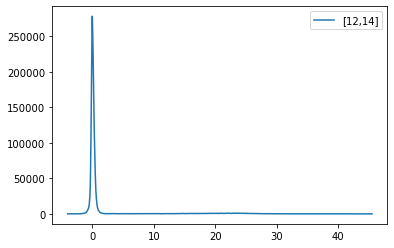

In [3]:
full_width, full_height = im.image_shape[1], im.image_shape[0]
loc_x, loc_y = int(0.1 * full_width), int(0.15 * full_height)
spectrum = im.plot_spectrum(loc_y, loc_x)

Next, we want to select only a subset of the entire image as our training data. It is important that the selected `window` covers pixels of more or less the same thickness. Running the cell below produces a heatmap of the integrated intensity accross the image, as well as a close-up of your selection. 

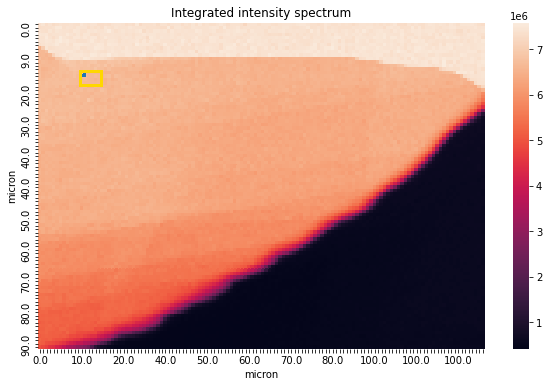

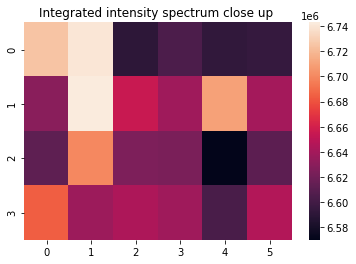

In [4]:
xmin, width = int(0.1 * full_width), int(0.05 * full_width)
ymin, height = int(0.15 * full_height), int(0.05 * full_height)

window = np.array([[xmin, width], [ymin, height]])
im.show_image(selection = window, pixel_highlight = [loc_x, loc_y])

## Selecting our training data

We cannot use the entire spectrum to train the ZLP, since low-loss features start to kick in relatively soon. Therefore, we construct three regions to further split up our training set. For energy losses $\Delta E \leq \Delta E_I$ (region 1), the ZLP dominates over the inelastic scatterings and so we can safely use this as our training data. For $\Delta E \geq \Delta E_{II}$ we use pseudo-data that drive the ZLP to zero (as it should). The EELS measurements in region 2, defined by $\Delta E_{I} \leq \Delta E \leq \Delta E_{II}$ are exclused from the training dataset.

To find "good" values of $\Delta E_I$ and $\Delta E_{II}$, we first need to smooth our data.

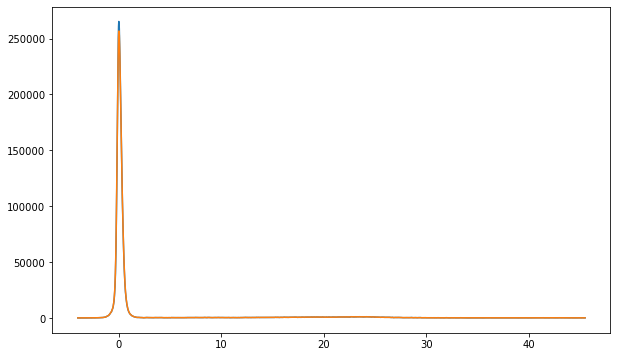

In [5]:
data_zoomed_concat = np.reshape(im.data_zoomed, (-1, im.l))
data_smooth = ZLPnn.smooth(data_zoomed_concat, window_len = 10)

# show the effect of smoothing on the second to last pixel
plt.figure(figsize=(10,6))
plt.plot(im.deltaE, im.data_zoomed[-1, -2, :])
plt.plot(im.deltaE, data_smooth[-2,:])
plt.show()

In the ultra-low loss region, characterised by $\Delta E \simeq$ few eV, the contributions of the ZLP and those from inealstic interactions become comparable. As a crude measure of where this region starts, we decide to look slightly to the left of the first local minimum in the EELS spectrum.

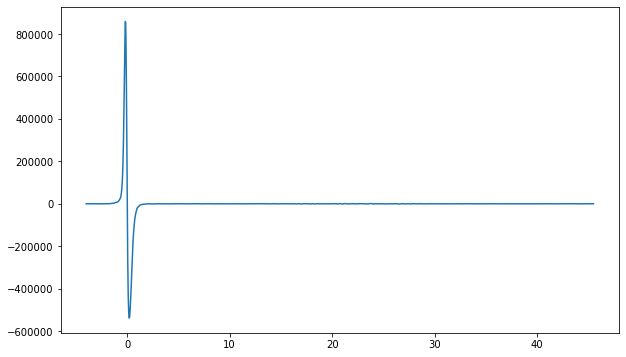

In [6]:
def der_spect(image, spectrum):
    dx = image.ddeltaE
    der_spectrum = (spectrum[:,1:]-spectrum[:,:-1])/dx
    return der_spectrum

der = der_spect(im, data_smooth)
der_smooth = ZLPnn.smooth(der, window_len = 10)

# plot the slope of the EELS spectrum
plt.figure(figsize=(10,6))
plt.plot(im.deltaE[:-1], der_smooth[-1,:])
plt.show()

Now we are ready to find $\Delta E_{I}$ and $\Delta E_{II}$

In [7]:
data_avg = np.average(data_smooth, axis=0)
der_avg = np.average(der, axis=0)

dE1 = ZLPnn.find_dE1(im, der_avg, data_avg, fct=0.7)


times_dE1 = 3 # multiplicative factor that determines the location of dE2
min_dE2 = im.deltaE.max() - im.ddeltaE * im.l * 0.05 
dE2 = np.minimum(dE1 * times_dE1, min_dE2) 

In [8]:
# selection indices 
select1 = len(im.deltaE[im.deltaE < dE1]) 
select2 = len(im.deltaE[im.deltaE > dE2])

## Rescaling our training data

To avoid our neurons from getting saturated and giving very small gradients, we will standardize our input features to zero mean and unit variance. This will significantly speed up the training of our neural network.

In [9]:
# Due to noise we have have some negative intensities. Set these to epsilon by hand.
epsilon = 1e-3
data_zoomed_concat[data_zoomed_concat < 0] = epsilon

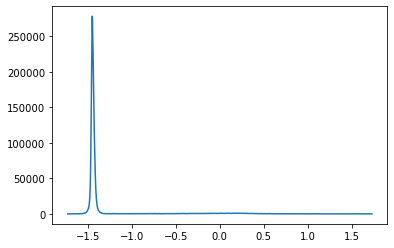

In [10]:
def rescale(data, mean, std):
    return (data - mean) / std

deltaE_scaled = rescale(im.deltaE, np.mean(im.deltaE), np.std(im.deltaE))

plt.plot(deltaE_scaled, data_zoomed_concat[0])

The cuts $\Delta E_I$ and $\Delta E_{II}$ still need to be applied though. Let us do this now and plot the result (we now plot the log of the intensity instead).

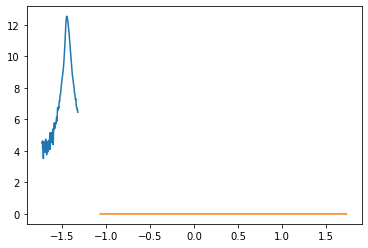

In [18]:
# input features
data_x = np.ones(select1 + select2)
data_x[:select1] = deltaE_scaled[:select1]
data_x[-select2:] = deltaE_scaled[-select2:]

# error on measured data
ci_low = np.nanpercentile(np.log(data_zoomed_concat), 16, axis=0)
ci_high = np.nanpercentile(np.log(data_zoomed_concat), 84, axis=0)
sigma = np.absolute(ci_high - ci_low)

data_sigma = sigma[:select1]
data_sigma = np.append(data_sigma, 0.8 * np.ones(select2))

# select a representative spectrum and plot 
data_y = np.log(data_zoomed_concat[0][:select1])
data_y = np.append(data_y, np.zeros(select2))
plt.plot(pseudo_x[:select1], data_y[:select1])
plt.plot(pseudo_x[-select2:], data_y[-select2:])

## Constructing the Neural Network

2021-06-02 12:47:25.755243 Replica 0, Epoch 1, Training loss 7867.2113084897555, Validation loss 10839.132990183272
2021-06-02 12:47:26.563139 Replica 0, Epoch 500, Training loss 64.88058730545148, Validation loss 93.24300364742325
2021-06-02 12:47:27.342886 Replica 0, Epoch 1000, Training loss 57.34930365003073, Validation loss 83.68877496711261
2021-06-02 12:47:28.088788 Replica 0, Epoch 1500, Training loss 57.20095560005538, Validation loss 83.7703268107379
2021-06-02 12:47:28.887518 Replica 0, Epoch 2000, Training loss 56.81801549230707, Validation loss 82.8838912975678
2021-06-02 12:47:29.612263 Replica 0, Epoch 2500, Training loss 56.63124001349007, Validation loss 82.58599915402631
2021-06-02 12:47:30.342301 Replica 0, Epoch 3000, Training loss 56.46653786785148, Validation loss 82.28923457273869
2021-06-02 12:47:31.077899 Replica 0, Epoch 3500, Training loss 56.32816498912771, Validation loss 82.01976378245686
2021-06-02 12:47:31.818352 Replica 0, Epoch 4000, Training loss 56.2

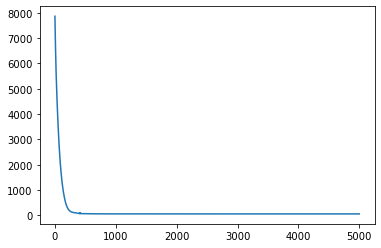

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import datetime

class MLP(nn.Module):

    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, 10)
        self.linear2 = nn.Linear(10, 15)
        self.linear3 = nn.Linear(15, 5)
        self.output = nn.Linear(5, num_outputs)
        self.tanh = nn.Tanh()
        #self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.tanh(x)
        x = self.linear2(x)
        x = self.tanh(x)
        x = self.linear3(x)
        x = self.tanh(x)
        x = self.output(x)
        return x
    
def loss_fn(output, target, error):
    loss = torch.mean(torch.square((output - target)/error))
    return loss

# def weight_reset(m):
#     if isinstance(m, nn.Linear):
#         m.reset_parameters()
        
        
def weights_init(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

def training_loop(n_rep, n_epochs, optimizer, model, loss_fn):
    
    #data_x = deltaE_scaled[:select1]
    #data_sigma = im.data_unc[:select1]
    
    for rep in range(n_rep):
        
        #model.apply(weights_init)
        
        data_y = np.log(data_zoomed_concat[rep][:select1])
        data_y = np.append(data_y, np.zeros(select2))
        
        #data_y = np.log(data_zoomed_concat[rep][:select1])
       
        train_x, test_x, train_y, test_y, train_sigma, test_sigma = train_test_split(pseudo_x, data_y, data_sigma, test_size=0.5)

        train_x = torch.tensor(train_x).unsqueeze(-1) 
        test_x = torch.tensor(test_x).unsqueeze(-1) 
        
        train_y = torch.tensor(train_y).unsqueeze(-1)
        test_y = torch.tensor(test_y).unsqueeze(-1)
        
        train_sigma = torch.tensor(train_sigma).unsqueeze(-1)
        test_sigma = torch.tensor(test_sigma).unsqueeze(-1)
        
        validation_loss = []
        training_loss = []
        loss_val_old = 0
        overfit_counter = 0
        patience = 10000
        for epoch in range(1, n_epochs + 1):
            
            loss_train = 0.0
            loss_val = 0.0
            
            model_output = model(train_x.float())
            
            loss = loss_fn(model_output, train_y, train_sigma)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            loss_train += loss.item()
            training_loss.append(loss_train)
        
            #validation loss
            
            with torch.no_grad():
                model_output = model(test_x.float())
                val_loss = loss_fn(model_output, test_y, test_sigma)
                loss_val += val_loss.item()
                validation_loss.append(loss_val)
                assert val_loss.requires_grad == False

#             model.eval()
#             with torch.no_grad():
#                 loss_val = 0.0
#                 model_output = model(test_x.float())
#                 loss = loss_fn(model_output, test_y, test_sigma)
                
#                 #assert loss_val.requires_grad is False
#                 loss_val += loss.item()
#                 validation_loss.append(loss_val)
             
#             if loss_val > loss_val_old and epoch > 1:
#                 overfit_counter += 1
                
#             if overfit_counter == patience:
#                 torch.save(model.state_dict(), './models/trained_nn_rep_{}.pt'.format(rep))
#                 print(loss_train, epoch)
#                 break
                
#             loss_val_old = loss_val
            
            if epoch == 1 or epoch % 500 == 0:
                print('{} Replica {}, Epoch {}, Training loss {}, Validation loss {}'.format(datetime.datetime.now(), rep, epoch, loss_train, loss_val))
        
        #print(validation_loss)
        torch.save(model.state_dict(), './models/trained_nn_rep_{}.pt'.format(rep))
        plt.plot(training_loss)

n_rep = im.data_zoomed.shape[0] * im.data_zoomed.shape[1]
n_epochs = 5000
model = MLP(num_inputs=1, num_outputs=1)
optimizer = optim.Adam(model.parameters(), lr=1e-2)                
                
training_loop(
    n_rep = 1,
    n_epochs = n_epochs,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn
)

Play with different optimizers/architectures/learning rates

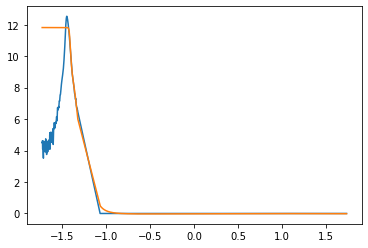

In [15]:
network_path = './models/trained_nn_rep_0.pt'
model.load_state_dict(torch.load(network_path))

#data_x = deltaE_scaled[:select1]
pseudo_x = torch.tensor(pseudo_x).unsqueeze(-1)

model_pred = model.forward(pseudo_x.float())
model_pred = model_pred.detach().numpy()

plt.plot(pseudo_x, data_y)
plt.plot(pseudo_x, model_pred)
#plt.plot(deltaE_scaled[:select1], np.log(im.data_zoomed_concat[0][:select1]))
plt.show()

## Training report

Plot of loss
validation set
adding dE2


## Evaluating the trained models

In [16]:
pred = []

for rep in range(0,n_rep):
    network_path = './models/trained_nn_rep_{}.pt'.format(rep)
    model.load_state_dict(torch.load(network_path))
    
    model_pred = model.forward(data_x.float())
    model_pred = model_pred.detach().numpy()
    pred.append(model_pred[:,0])

pred = np.array(pred)
pred_median = np.median(pred, axis=0)
cl_low = np.nanpercentile(pred, 16, axis=0)
cl_high = np.nanpercentile(pred, 84, axis=0)

plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
plt.plot(deltaE_scaled[:select1], pred_median)
ax.fill_between(deltaE_scaled[:select1], cl_low, cl_high, alpha = 0.3)
plt.show()

NameError: name 'data_x' is not defined

Discuss with Isabel: pretrained models

## ZLP subtraction

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(im.deltaE, data_zoomed_concat[-2], linestyle='dashed', label='original', color='k')
plt.fill_between(im.deltaE[:select1], np.exp(cl_low), np.exp(cl_high), alpha = 0.4, label='ZLP', color='C1')
plt.plot(im.deltaE[:select1], np.exp(pred_median), linestyle = 'dashed', color='C1')
plt.plot(im.deltaE[:select1], data_zoomed_concat[0][:select1]-np.exp(pred_median), linestyle='dashed')
plt.fill_between(im.deltaE[:select1], data_zoomed_concat[0][:select1] - np.exp(cl_low), data_zoomed_concat[0][:select1] - np.exp(cl_high), alpha = 0.4, label='subtracted', color='C0')
plt.xlim(-1.2, 4.5)
plt.legend()
plt.show()

## Bandgap fit

### Question 1: 
Explain what would go wrong if instead we also include training data from region 2.